In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
overwrite_model=False
restore_model=True
train_model=False

In [3]:
import os
os.environ['JAX_PLATFORMS']="cpu"
# os.environ['JAX_PLATFORMS']="cuda"


import sys
sys.path.append("./src")

from flax import nnx
import jax 
import jax.numpy as jnp
import optax
import numpy as np

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

import time
import diffrax

In [4]:
import orbax.checkpoint as ocp
checkpoint_dir = "/lhome/ific/a/aamerio/github/cfm-jax/checkpoints/sbi_test"

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

In [5]:
import jax
import jax.numpy as jnp
from jax import random
from functools import partial

@partial(jax.jit, static_argnums=[1,2,3])  # type: ignore
def make_moons_jax(key, n_samples=100, shuffle=True, noise=None):
    """Make two interleaving half circles using JAX.

    Args:
        n_samples: The total number of points generated.
        shuffle: Whether to shuffle the samples.
        noise: Standard deviation of Gaussian noise added to the data.
        random_state: A JAX random.PRNGKey for reproducibility.

    Returns:
        X: A JAX array of shape (n_samples, 2) containing the generated samples.
        y: A JAX array of shape (n_samples,) containing the integer labels (0 or 1)
           for class membership of each sample.
    """

    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    # Generate points for the outer moon (label 0)
    outer_circ_t = random.uniform(key, shape=(n_samples_out,)) * jnp.pi
    key, subkey = random.split(key)
    outer_circ_x = jnp.cos(outer_circ_t)
    outer_circ_y = jnp.sin(outer_circ_t)
    X_outer = jnp.vstack([outer_circ_x, outer_circ_y]).T

    # Generate points for the inner moon (label 1)
    inner_circ_t = random.uniform(subkey, shape=(n_samples_in,)) * jnp.pi
    key, subkey = random.split(key)
    inner_circ_x = 1 - jnp.cos(inner_circ_t)
    inner_circ_y = 0.5 - jnp.sin(inner_circ_t)
    X_inner = jnp.vstack([inner_circ_x, inner_circ_y]).T

    # Combine the moons
    X = jnp.vstack([X_outer, X_inner])
    y = jnp.hstack([jnp.zeros(n_samples_out, dtype=jnp.int32), jnp.ones(n_samples_in, dtype=jnp.int32)])

    if noise is not None:
        # Add Gaussian noise
        key, subkey = random.split(key)
        X += random.normal(subkey, shape=X.shape) * noise

    if shuffle:
        # Shuffle the data
        key, subkey = random.split(key)
        permutation = random.permutation(subkey, n_samples)
        X = X[permutation]
        y = y[permutation]

    return X, y



@partial(jax.jit, static_argnums=[1])  # type: ignore
def make_boxes_jax(key, batch_size: int = 200):
    """
    Generates a batch of 2D data points similar to the original PyTorch function
    using JAX.

    Args:
        key: A JAX PRNG key for random number generation.
        batch_size: The number of data points to generate.

    Returns:
        A JAX array of shape (batch_size, 2) with generated data,
        with dtype float32.
    """
    # Split the key for different random operations
    keys = jax.random.split(key, 3)
    x1 = jax.random.uniform(keys[0],batch_size) * 4 - 2
    x2_ = jax.random.uniform(keys[1],batch_size) - jax.random.randint(keys[2], batch_size, 0,2) * 2
    x2 = x2_ + (jnp.floor(x1) % 2)

    data = 1.0 * jnp.concatenate([x1[:, None], x2[:, None]], axis=1) / 0.45
    
    return data

In [6]:
# @partial(jax.jit, static_argnums=[1])  # type: ignore
# def inf_train_gen(key, batch_size: int = 200):
#     x = make_moons_jax(key, batch_size, shuffle=True, noise=0.1)[0]

#     return x

@partial(jax.jit, static_argnums=[1])  # type: ignore
def inf_train_gen(key, batch_size: int = 200):
    x = make_boxes_jax(key, batch_size)

    return x

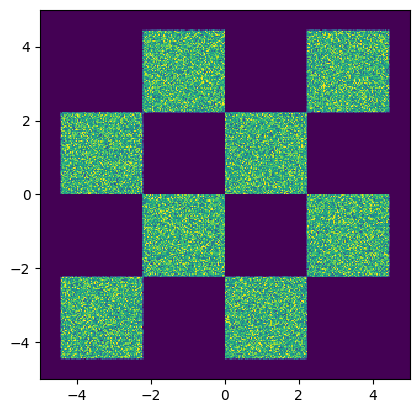

In [7]:
samples = inf_train_gen(jax.random.PRNGKey(0), 500_000)

H=plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

_ = plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)), norm=norm)

# set equal ratio of axes
plt.gca().set_aspect('equal', adjustable='box')


plt.show()

In [8]:
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver
from flow_matching.utils import ModelWrapper
from flow_matching.loss import ContinuousFMLoss

/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
class MLP(nnx.Module):
    def __init__(self, input_dim: int = 2, hidden_dim: int = 128, *, rngs: nnx.Rngs):

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        din = input_dim + 1

        self.linear1 = nnx.Linear(din, self.hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear3 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear4 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear5 = nnx.Linear(self.hidden_dim, self.input_dim, rngs=rngs)

    def __call__(self, x: jax.Array, t: jax.Array, args=None):
        x = jnp.atleast_2d(x)
        t = jnp.atleast_1d(t)
        if len(t.shape)<2:
            t = t[..., None]
            t = jnp.broadcast_to(t, (x.shape[0], t.shape[-1]))
            
        h = jnp.concatenate([x, t], axis=-1)

        x = self.linear1(h)
        x = jax.nn.gelu(x)

        x = self.linear2(x)
        x = jax.nn.gelu(x)

        x = self.linear3(x)
        x = jax.nn.gelu(x)

        x = self.linear4(x)
        x = jax.nn.gelu(x)

        x = self.linear5(x)

        return x

In [10]:
# training arguments
lr = 0.001
iterations = 20001
print_every = 2000
hidden_dim = 512

# velocity field model init
vf_model = MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0))

# init optimizer
optimizer = nnx.Optimizer(vf_model, optax.adam(lr))

In [11]:
# restore the model
if restore_model:
    model_state = nnx.state(vf_model)

    with ocp.CheckpointManager(
        checkpoint_dir, options=ocp.CheckpointManagerOptions(read_only=True)
    ) as read_mgr:
        restored = read_mgr.restore(
            1,
            # pass in the model_state to restore the exact same State type
            args=ocp.args.Composite(state=ocp.args.PyTreeRestore(item=model_state))
        )


    abstract_model = MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0))
    graphdef, abstract_state = nnx.split(abstract_model)

    vf_model= nnx.merge(graphdef, restored["state"])

ERROR:absl:File /lhome/ific/a/aamerio/github/cfm-jax/checkpoints/sbi_test/1/metrics/metrics not found.
/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [12]:
batch_size = 1024

In [13]:
# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

loss_fn = ContinuousFMLoss(path)

@nnx.jit
def train_step(vf_model, optimizer, batch):
    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(vf_model, batch)
    optimizer.update(grads)  # In-place updates.

    return loss

In [14]:
if train_model:
    vf_model.train()

    start_time = time.time()
    key = jax.random.PRNGKey(0)
    for i in range(iterations):
        key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
        x_1 = inf_train_gen(subkey1, batch_size=batch_size) # sample data
        x_0 = jax.random.normal(subkey2, x_1.shape)
        t = jax.random.uniform(subkey3, x_1.shape[0])

        batch = (x_0, x_1, t)
        loss = train_step(vf_model, optimizer, batch)  # update model parameters

        # log loss
        if (i+1) % print_every == 0:
            elapsed = time.time() - start_time
            print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
                .format(i+1, elapsed*1000/print_every, loss.item()))
            start_time = time.time()

    vf_model.eval()

In [15]:
# save the model
if train_model:
    checkpoint_manager = ocp.CheckpointManager(checkpoint_dir,
        options=ocp.CheckpointManagerOptions(
            max_to_keep=2,
            keep_checkpoints_without_metrics=False,
            create=True,
        ),
    )
    model_state = nnx.state(vf_model)
    checkpoint_manager.save(
        1, args=ocp.args.Composite(state=ocp.args.PyTreeSave(model_state))
    )

    checkpoint_manager.close()

# sample the model

In [16]:
vf_model.eval()

In [17]:
vf_wrapped = ModelWrapper(vf_model)

In [18]:
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 50000  # batch size
# eps_time = 1e-2
T = jnp.linspace(0,1,10)  # sample times

# x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
x_init = jax.random.normal(jax.random.PRNGKey(0), (batch_size, 2))  # initial conditions
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='Dopri5', step_size=step_size, return_intermediates=True)

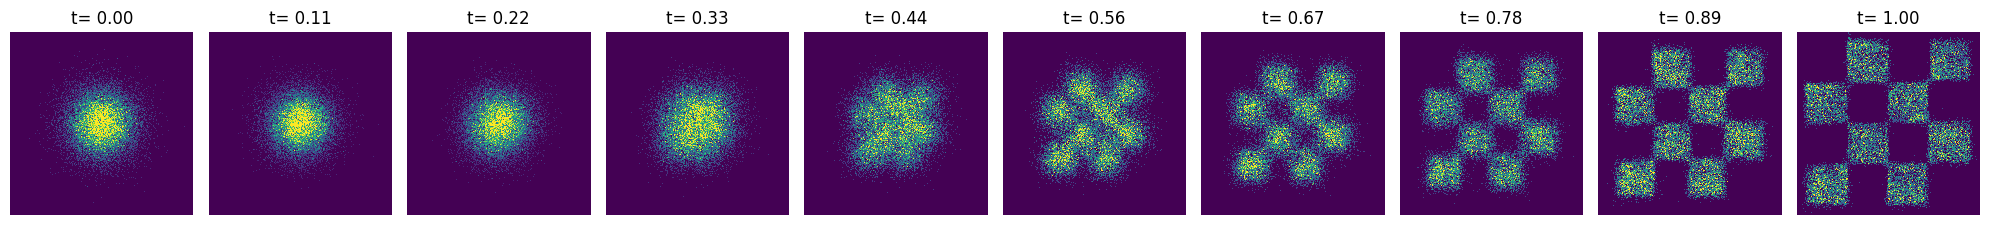

In [19]:
sol = np.array(sol)  # convert to numpy array
T = np.array(T)  # convert to numpy array

fig, axs = plt.subplots(1, 10, figsize=(20,20))

for i in range(10):
    H = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)))
    
    cmin = 0.0
    cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm)
    
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))
    
plt.tight_layout()
plt.show()

In [44]:
x_init = jax.random.normal(jax.random.PRNGKey(0), (100_000, 2))  # initial conditions
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
samples = solver.sample(x_init=x_init, method='Dopri5', step_size=step_size)

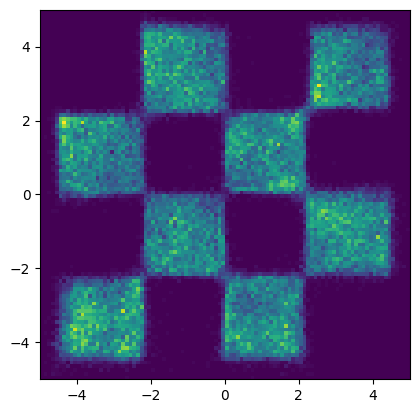

In [45]:
plt.hist2d(samples[:,0], samples[:,1], 100, range=((-5,5), (-5,5)))
# set equal ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [20]:
batch_size = 1000
T = jnp.linspace(0,1,50)  # sample times

# x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
x_init = jax.random.normal(jax.random.PRNGKey(0), (batch_size, 2))  # initial conditions
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='Dopri5', step_size=step_size, return_intermediates=True)

In [21]:
from flow_matching.utils import plot_trajectories

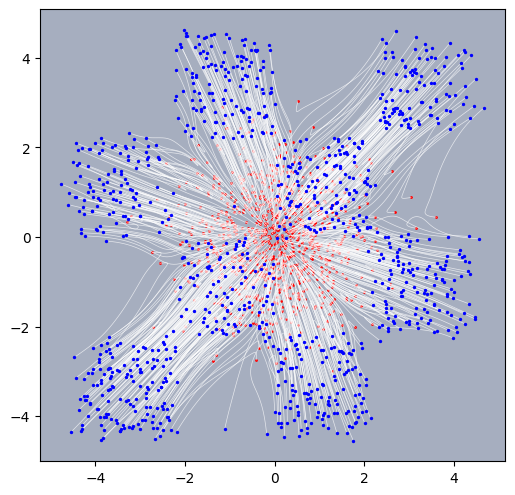

In [22]:
fig, ax = plot_trajectories(sol)
plt.show()

# sample the likelihood

In [23]:
import numpyro.distributions as dist

In [24]:
# sample with likelihood

T = jnp.array([1., 0.])  # sample times
grid_size = 200
x_1 = jnp.meshgrid(jnp.linspace(-5, 5, grid_size), jnp.linspace(-5, 5, grid_size))
x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

In [25]:
# source distribution is an isotropic gaussian
gaussian_log_density = dist.Independent(dist.Normal(jnp.zeros(2), jnp.ones(2)), 1).log_prob

In [26]:
sampler = solver.get_unnormalized_logprob(time_grid=[1.0,0.0], method='Dopri5', step_size=step_size, log_p0=gaussian_log_density)

_, exact_log_p = sampler(x_1)

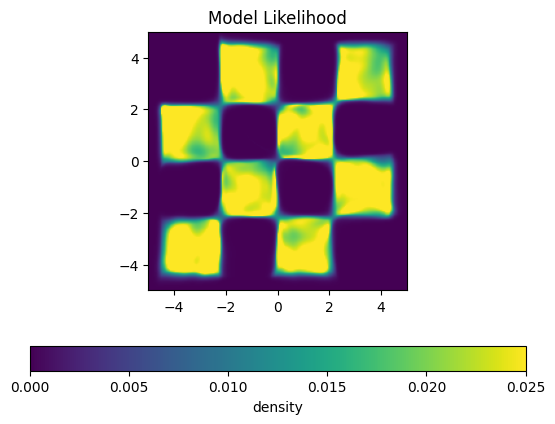

In [27]:
likelihood = np.array(jnp.exp(exact_log_p[-1,:]).reshape(grid_size, grid_size))


# cmin = 0.0
# cmax = 1/32 # 1/32 is the gt likelihood value
cmin = 0 
cmax = 1/40

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

# Create the figure and axis objects explicitly
fig, ax = plt.subplots()

likelihood = np.array(jnp.exp(exact_log_p[-1,:]).reshape(grid_size, grid_size))

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

im = ax.imshow(likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
# im = ax.imshow(likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis')
ax.set_title('Model Likelihood')

# plt.scatter(sol[0,:,0], sol[0,:,1], color="red", s=1, alpha=0.5)
# plt.plot(sol[:,:,0], sol[:,:,1], color="white", lw=0.2, alpha=0.7)
# plt.scatter(sol[-1,:,0], sol[-1,:,1], color="blue", s=2, alpha=1, zorder=2)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()

# Use the current figure/axis for the colorbar
plt.colorbar(im, ax=ax, orientation='horizontal', label='density')
plt.show()

# stochastic sampler 

In [46]:
from flow_matching.solver import ZeroEnds

In [52]:
mu0 = jnp.zeros(2)
sigma0 = jnp.ones(2)
alpha = 0.1

In [58]:
ze = ZeroEnds(vf_wrapped, mu0=mu0, sigma0=sigma0, alpha=alpha, eps0=0)

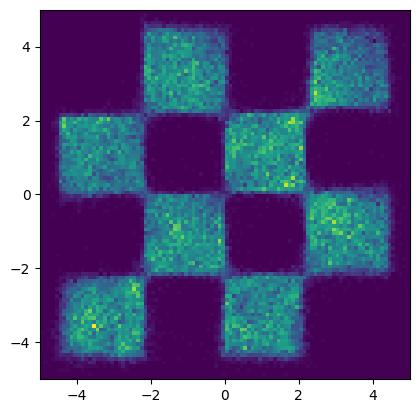

In [62]:
sampler = ze.get_sampler(nsteps=30, method="Euler")
key = jax.random.PRNGKey(0)
samples_sea = sampler(key, 100_000)

plt.hist2d(samples_sea[:,0], samples_sea[:,1], 100, range=((-5,5), (-5,5)))
# set equal ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

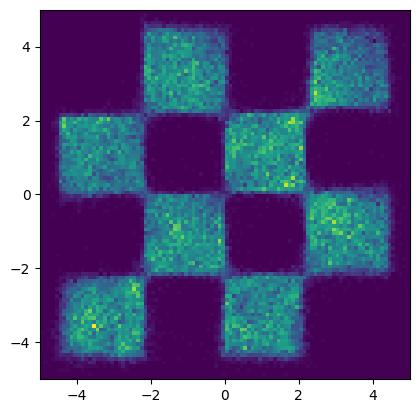

In [63]:
sampler = ze.get_sampler(nsteps=30, method="Euler")
key = jax.random.PRNGKey(0)
samples_euler = sampler(key, 100_000)

plt.hist2d(samples_euler[:,0], samples_euler[:,1], 100, range=((-5,5), (-5,5)))
# set equal ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

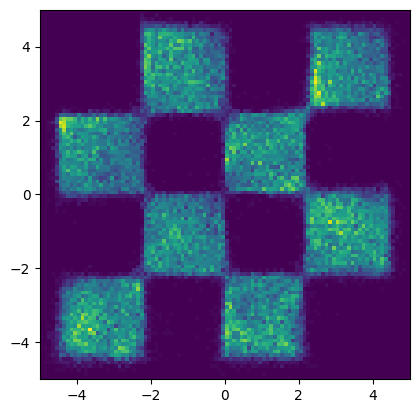

In [64]:
sampler = ze.get_sampler(nsteps=30, method="ShARK", adaptive=True)
key = jax.random.PRNGKey(0)
samples_shark_a = sampler(key, 100_000)

plt.hist2d(samples_shark_a[:,0], samples_shark_a[:,1], 100, range=((-5,5), (-5,5)))
# set equal ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

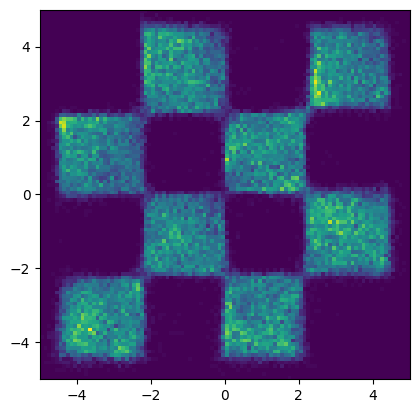

In [65]:
sampler = ze.get_sampler(nsteps=30, method="ShARK", adaptive=False)
key = jax.random.PRNGKey(0)
samples_shark_b = sampler(key, 100_000)

plt.hist2d(samples_shark_b[:,0], samples_shark_b[:,1], 100, range=((-5,5), (-5,5)))
# set equal ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.show()